# Zbuduj model klasyfikacji: Pyszne azjatyckie i indyjskie kuchnie


## Klasyfikatory kuchni 1

W tej lekcji przyjrzymy się różnym klasyfikatorom, aby *przewidzieć daną kuchnię narodową na podstawie grupy składników.* Przy okazji dowiemy się więcej o sposobach wykorzystania algorytmów w zadaniach klasyfikacyjnych.

### [**Quiz przed wykładem**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Przygotowanie**

Ta lekcja opiera się na naszej [poprzedniej lekcji](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb), w której:

-   Wprowadziliśmy łagodnie klasyfikacje, korzystając z zestawu danych o wszystkich wspaniałych kuchniach Azji i Indii 😋.

-   Zbadaliśmy kilka [czasowników dplyr](https://dplyr.tidyverse.org/) do przygotowania i czyszczenia danych.

-   Stworzyliśmy piękne wizualizacje za pomocą ggplot2.

-   Pokazaliśmy, jak radzić sobie z niezrównoważonymi danymi, przetwarzając je za pomocą [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Zademonstrowaliśmy, jak `prep` i `bake` nasz przepis, aby upewnić się, że działa zgodnie z oczekiwaniami.

#### **Wymagania wstępne**

Do tej lekcji będziemy potrzebować następujących pakietów do czyszczenia, przygotowania i wizualizacji danych:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) to [zbiór pakietów R](https://www.tidyverse.org/packages) zaprojektowany, aby uczynić naukę o danych szybszą, łatwiejszą i bardziej przyjemną!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) to [framework](https://www.tidymodels.org/packages/) składający się z pakietów do modelowania i uczenia maszynowego.

-   `themis`: [pakiet themis](https://themis.tidymodels.org/) dostarcza dodatkowe kroki w recipes do radzenia sobie z niezrównoważonymi danymi.

-   `nnet`: [pakiet nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) oferuje funkcje do szacowania sieci neuronowych typu feed-forward z jedną ukrytą warstwą oraz modele regresji logistycznej wielomianowej.

Możesz je zainstalować jako:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternatywnie, poniższy skrypt sprawdza, czy masz zainstalowane pakiety potrzebne do ukończenia tego modułu i instaluje je, jeśli ich brakuje.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Podziel dane na zestawy treningowe i testowe.

Zaczniemy od wybrania kilku kroków z naszej poprzedniej lekcji.

### Usuń najczęściej występujące składniki, które powodują zamieszanie między różnymi kuchniami, używając `dplyr::select()`.

Wszyscy uwielbiają ryż, czosnek i imbir!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Świetnie! Teraz czas podzielić dane tak, aby 70% danych trafiło do treningu, a 30% do testów. Zastosujemy również technikę `stratyfikacji` podczas podziału danych, aby `zachować proporcje każdej kuchni` w zbiorach treningowych i walidacyjnych.

[rsample](https://rsample.tidymodels.org/), pakiet w Tidymodels, zapewnia infrastrukturę do efektywnego podziału danych i próbkowania:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Radzenie sobie z niezrównoważonymi danymi

Jak zapewne zauważyłeś w oryginalnym zestawie danych, a także w naszym zestawie treningowym, istnieje dość nierównomierny rozkład liczby kuchni. Kuchnia koreańska jest *prawie* 3 razy liczniejsza niż kuchnia tajska. Niezrównoważone dane często mają negatywny wpływ na wydajność modelu. Wiele modeli działa najlepiej, gdy liczba obserwacji jest równa, przez co mają trudności z przetwarzaniem niezrównoważonych danych.

Istnieją dwa główne sposoby radzenia sobie z niezrównoważonymi zestawami danych:

-   dodawanie obserwacji do klasy mniejszościowej: `Oversampling`, np. za pomocą algorytmu SMOTE, który syntetycznie generuje nowe przykłady klasy mniejszościowej, wykorzystując najbliższych sąsiadów tych przypadków.

-   usuwanie obserwacji z klasy większościowej: `Undersampling`

W naszej poprzedniej lekcji pokazaliśmy, jak radzić sobie z niezrównoważonymi zestawami danych, korzystając z `recipe`. Recipe można traktować jako plan działania, który opisuje, jakie kroki należy zastosować do zestawu danych, aby przygotować go do analizy. W naszym przypadku chcemy uzyskać równomierny rozkład liczby kuchni w naszym `zestawie treningowym`. Przejdźmy do działania.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Możesz oczywiście potwierdzić (używając prep+bake), że przepis działa zgodnie z oczekiwaniami - wszystkie etykiety kuchni mają `559` obserwacji.

Ponieważ będziemy używać tego przepisu jako preprocessora do modelowania, `workflow()` zajmie się całym przygotowaniem i pieczeniem za nas, więc nie będziemy musieli ręcznie szacować przepisu.

Teraz jesteśmy gotowi, aby trenować model 👩‍💻👨‍💻!

## 3. Wybór klasyfikatora

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Ilustracja autorstwa @allison_horst</figcaption>


Teraz musimy zdecydować, którego algorytmu użyć do zadania 🤔.

W Tidymodels, [`pakiet parsnip`](https://parsnip.tidymodels.org/index.html) zapewnia spójny interfejs do pracy z modelami w różnych silnikach (pakietach). Zobacz dokumentację parsnip, aby zapoznać się z [typami modeli i silnikami](https://www.tidymodels.org/find/parsnip/#models) oraz ich odpowiadającymi [argumentami modeli](https://www.tidymodels.org/find/parsnip/#model-args). Różnorodność może być na pierwszy rzut oka przytłaczająca. Na przykład, poniższe metody obejmują techniki klasyfikacji:

-   Modele klasyfikacji oparte na regułach C5.0

-   Elastyczne modele dyskryminacyjne

-   Liniowe modele dyskryminacyjne

-   Regularizowane modele dyskryminacyjne

-   Modele regresji logistycznej

-   Modele regresji wielomianowej

-   Modele Naive Bayes

-   Maszyny wektorów nośnych

-   Najbliżsi sąsiedzi

-   Drzewa decyzyjne

-   Metody zespołowe

-   Sieci neuronowe

Lista jest długa!

### **Który klasyfikator wybrać?**

Więc, który klasyfikator powinieneś wybrać? Często przetestowanie kilku i poszukiwanie dobrego wyniku jest sposobem na sprawdzenie.

> AutoML rozwiązuje ten problem w elegancki sposób, przeprowadzając te porównania w chmurze, co pozwala wybrać najlepszy algorytm dla Twoich danych. Wypróbuj to [tutaj](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Wybór klasyfikatora zależy również od naszego problemu. Na przykład, gdy wynik można podzielić na `więcej niż dwie klasy`, jak w naszym przypadku, musisz użyć `algorytmu klasyfikacji wieloklasowej`, zamiast `klasyfikacji binarnej.`

### **Lepsze podejście**

Lepszym sposobem niż zgadywanie jest skorzystanie z pomysłów zawartych w tej dostępnej do pobrania [ściągawce ML](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Tutaj odkrywamy, że dla naszego problemu wieloklasowego mamy kilka opcji:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Fragment ściągawki algorytmów Microsoftu, przedstawiający opcje klasyfikacji wieloklasowej</figcaption>


### **Rozumowanie**

Przeanalizujmy różne podejścia, biorąc pod uwagę ograniczenia, które mamy:

-   **Głębokie sieci neuronowe są zbyt ciężkie.** Biorąc pod uwagę nasz czysty, ale minimalny zbiór danych oraz fakt, że trenujemy lokalnie w notebookach, głębokie sieci neuronowe są zbyt skomplikowane dla tego zadania.

-   **Brak klasyfikatora dwuklasowego.** Nie używamy klasyfikatora dwuklasowego, co wyklucza podejście one-vs-all.

-   **Drzewo decyzyjne lub regresja logistyczna mogą się sprawdzić.** Drzewo decyzyjne może być odpowiednie, podobnie jak regresja wielomianowa/wieloklasowa regresja logistyczna dla danych wieloklasowych.

-   **Wieloklasowe wzmocnione drzewa decyzyjne rozwiązują inny problem.** Wieloklasowe wzmocnione drzewo decyzyjne najlepiej nadaje się do zadań nieparametrycznych, np. budowania rankingów, więc nie jest przydatne w naszym przypadku.

Zazwyczaj, zanim przejdziemy do bardziej złożonych modeli uczenia maszynowego, takich jak metody zespołowe, warto zacząć od najprostszego możliwego modelu, aby zrozumieć, co się dzieje. Dlatego w tej lekcji zaczniemy od modelu `regresji wielomianowej`.

> Regresja logistyczna to technika stosowana, gdy zmienna wynikowa jest kategoryczna (lub nominalna). W przypadku regresji logistycznej binarnej liczba zmiennych wynikowych wynosi dwie, podczas gdy w regresji logistycznej wielomianowej liczba zmiennych wynikowych jest większa niż dwie. Zobacz [Zaawansowane metody regresji](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html), aby dowiedzieć się więcej.

## 4. Trenuj i oceń model regresji logistycznej wielomianowej.

W Tidymodels, `parsnip::multinom_reg()` definiuje model, który wykorzystuje predyktory liniowe do przewidywania danych wieloklasowych przy użyciu rozkładu wielomianowego. Zobacz `?multinom_reg()`, aby dowiedzieć się o różnych sposobach/silnikach, które można wykorzystać do dopasowania tego modelu.

W tym przykładzie dopasujemy model regresji wielomianowej za pomocą domyślnego silnika [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Wartość dla `penalty` wybrałem dość losowo. Istnieją lepsze sposoby na wybór tej wartości, np. poprzez użycie `resamplingu` i `strojenia` modelu, o czym będziemy mówić później.
>
> Zobacz [Tidymodels: Pierwsze kroki](https://www.tidymodels.org/start/tuning/), jeśli chcesz dowiedzieć się więcej o strojeniu hiperparametrów modelu.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Świetna robota 🥳! Teraz, gdy mamy przepis i specyfikację modelu, musimy znaleźć sposób na połączenie ich w jeden obiekt, który najpierw przetworzy dane, następnie dopasuje model do przetworzonych danych, a także umożliwi potencjalne działania post-processingowe. W Tidymodels ten wygodny obiekt nazywa się [`workflow`](https://workflows.tidymodels.org/) i wygodnie przechowuje komponenty modelowania! To jest to, co w *Pythonie* nazywalibyśmy *pipeline*.

Więc połączmy wszystko w workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Przepływy pracy 👌👌! **`workflow()`** można dopasować w podobny sposób jak model. Czas więc na trenowanie modelu!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Wynik pokazuje współczynniki, które model nauczył się podczas treningu.

### Ocena Wytrenowanego Modelu

Czas sprawdzić, jak model sobie poradził 📏, oceniając go na zestawie testowym! Zacznijmy od wykonania prognoz na zestawie testowym.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Świetna robota! W Tidymodels ocena wydajności modelu może być przeprowadzona za pomocą [yardstick](https://yardstick.tidymodels.org/) - pakietu używanego do mierzenia skuteczności modeli za pomocą metryk wydajności. Tak jak w naszej lekcji dotyczącej regresji logistycznej, zacznijmy od obliczenia macierzy pomyłek.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Podczas pracy z wieloma klasami, zazwyczaj bardziej intuicyjne jest przedstawienie tego jako mapę cieplną, tak jak tutaj:


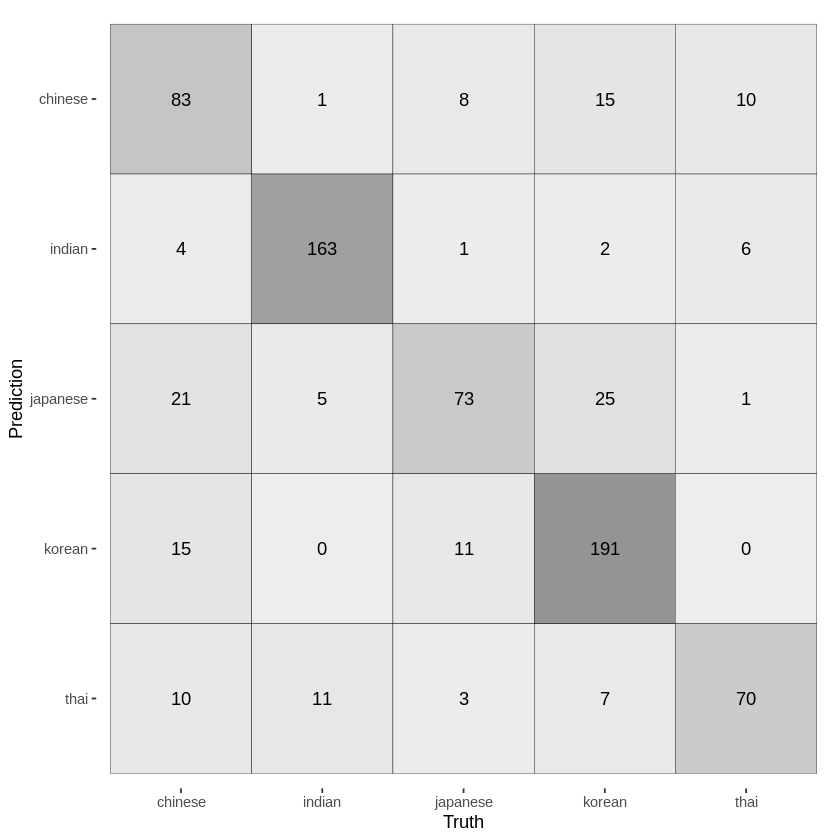

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Ciemniejsze kwadraty na wykresie macierzy pomyłek wskazują na dużą liczbę przypadków, a diagonalna linia ciemniejszych kwadratów powinna wskazywać przypadki, w których przewidywana i rzeczywista etykieta są takie same.

Przejdźmy teraz do obliczenia statystyk podsumowujących dla macierzy pomyłek.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Jeśli skupimy się na niektórych metrykach, takich jak dokładność, czułość, ppv, to na początek nie jest źle 🥳!

## 4. Zgłębianie tematu

Zadajmy jedno subtelne pytanie: Jakie kryteria są używane, aby wybrać dany typ kuchni jako przewidywany wynik?

Otóż statystyczne algorytmy uczenia maszynowego, takie jak regresja logistyczna, opierają się na `prawdopodobieństwie`; więc to, co faktycznie przewiduje klasyfikator, to rozkład prawdopodobieństwa dla zestawu możliwych wyników. Klasa z najwyższym prawdopodobieństwem jest następnie wybierana jako najbardziej prawdopodobny wynik dla danych obserwacji.

Zobaczmy to w praktyce, wykonując zarówno twarde przewidywania klas, jak i prawdopodobieństwa.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ Czy możesz wyjaśnić, dlaczego model jest pewien, że pierwsza obserwacja dotyczy kuchni tajskiej?

## **🚀Wyzwanie**

W tej lekcji użyłeś oczyszczonych danych, aby zbudować model uczenia maszynowego, który potrafi przewidzieć narodową kuchnię na podstawie serii składników. Poświęć trochę czasu na zapoznanie się z [wieloma opcjami](https://www.tidymodels.org/find/parsnip/#models), które oferuje Tidymodels do klasyfikacji danych, oraz [innymi sposobami](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) dopasowania regresji wielomianowej.

#### PODZIĘKOWANIA DLA:

[`Allison Horst`](https://twitter.com/allison_horst/) za stworzenie niesamowitych ilustracji, które sprawiają, że R jest bardziej przyjazny i angażujący. Więcej ilustracji znajdziesz w jej [galerii](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) i [Jen Looper](https://www.twitter.com/jenlooper) za stworzenie oryginalnej wersji tego modułu w Pythonie ♥️

<br>
Dorzuciłbym kilka żartów, ale nie rozumiem kulinarnych kalamburów 😅.

<br>

Miłego nauki,

[Eric](https://twitter.com/ericntay), Złoty Ambasador Studentów Microsoft Learn.



---

**Zastrzeżenie**:  
Ten dokument został przetłumaczony za pomocą usługi tłumaczenia AI [Co-op Translator](https://github.com/Azure/co-op-translator). Chociaż dokładamy wszelkich starań, aby zapewnić poprawność tłumaczenia, prosimy pamiętać, że automatyczne tłumaczenia mogą zawierać błędy lub nieścisłości. Oryginalny dokument w jego rodzimym języku powinien być uznawany za wiarygodne źródło. W przypadku informacji o kluczowym znaczeniu zaleca się skorzystanie z profesjonalnego tłumaczenia przez człowieka. Nie ponosimy odpowiedzialności za jakiekolwiek nieporozumienia lub błędne interpretacje wynikające z użycia tego tłumaczenia.
